In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from navigation_game import NavigableNetwork
import scipy
import seaborn as sns
import numpy as np

In [3]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


<Axes: >

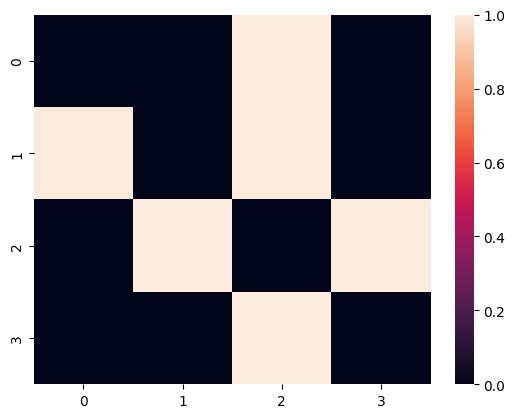

In [4]:
sns.heatmap(equilibrium)

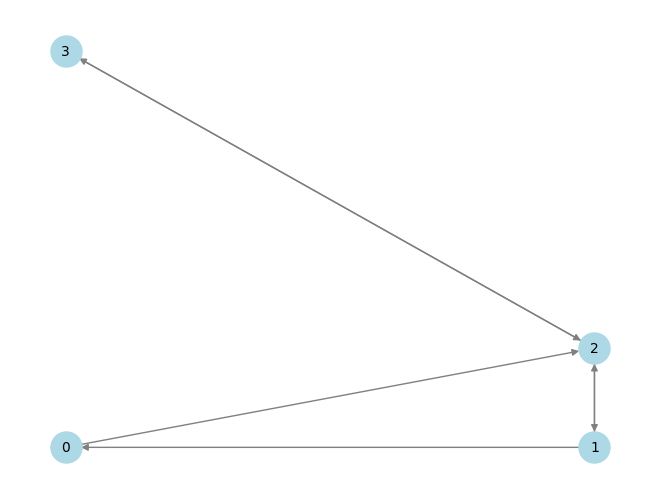

In [5]:
import networkx as nx

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [6]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]


In [7]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()

<Axes: >

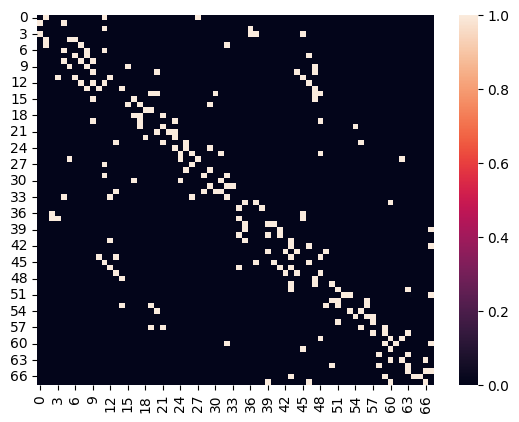

In [8]:
sns.heatmap(nash_network.astype(int))

<Axes: >

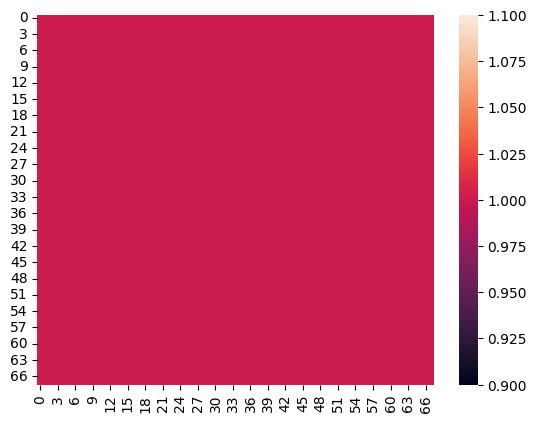

In [9]:
sns.heatmap(scipy.linalg.expm(nash_network).astype(bool))